# Check Loglikelihood with Lapse Rate

2/2
After having checked correlation between LL and EM fits, it seemed that the sigma_output was not that great. Namely, LL required non-zero sigma_output, even though it's negatively correlated with good EM Kappa fits.

Perhaps that was due to a lack of support for outliers, so now we allow that with a non-zero lapse rate. This is quite drastic currently, might need to switch to log(lapse_rate) samples to make sure it's close to 0.

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [3]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [4]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

:0: FutureWarning:

IPython widgets are experimental and may change in the future.



<IPython.core.display.Javascript object>

In [5]:
%run reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py

Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-2a25bcad-3d59-4faa-bf4c-ae156c85fb92.npy
0.00%, -- left - 14.10 23:23
M 350.00, ratio_conj 0.10, sigmax 0.32, lapse_rate 0.23
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_rando

In [6]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [7]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
lapserate_space = data_pbs.loaded_data['parameters_uniques']['lapse_rate']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [8]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [9]:
def sort_df_best_params(df_to_use, metric, nb_params):
    return df_to_use.sort(metric)[:nb_params]

def print_str_best_params_df(df_to_use, metric, nb_params):
    df_sorted = sort_df_best_params(df_to_use, metric, nb_params)

    print 'Best for %s' % metric
    for row_i, row in df_sorted.iterrows():
        print "[{:3d}] ".format(row_i) + \
        ' '.join(["%s %.4f" % (param, row[param]) for param in parameter_names_sorted]) + \
        ' >> %f' % row[metric]


In [10]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)
T_space = data_groundtruth['data_to_fit']['n_items']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_allitems.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays.pickle


In [11]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  510


In [12]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)

## -> Pandas now

In [13]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                             ('ratio_conj', result_parameters_flat[:, 1]),
                             ('sigmax', result_parameters_flat[:, 2]),
                             ('lapse_rate', result_parameters_flat[:, 3]),
                             ('dist_emfit_mse', result_dist_emfit_mse),
                             ('dist_emfit_kl', result_dist_emfit_kl),
                             ('dist_nll', result_dist_nll),
                             ('dist_nll90', result_dist_nll90),
                            ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                   dist_nll_log = lambda x: np.log(x['dist_nll'])
                                  )

In [38]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 3500
LL_min_cutoff = 700
lapserate_cutoff = 0.5
sigmax_min_cutoff = 0.05

df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_max_cutoff]
df_best_fits = df_best_fits[df_best_fits.dist_nll > LL_min_cutoff]
df_best_fits = df_best_fits[df_best_fits.lapse_rate < lapserate_cutoff]
df_best_fits = df_best_fits[df_best_fits.sigmax > sigmax_min_cutoff]

In [39]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,lapse_rate,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_emfit_mse_log,dist_nll_log
M,1.000000,0.366158,0.169240,0.102288,0.116689,0.022653,0.303738,0.166742,0.174957,0.304972
ratio_conj,0.366158,1.000000,0.073152,-0.178780,-0.192030,-0.398086,-0.344311,-0.441759,-0.475021,-0.341130
sigmax,0.169240,0.073152,1.000000,-0.122105,-0.185594,0.619753,0.412435,0.442094,-0.316862,0.429219
lapse_rate,0.102288,-0.178780,-0.122105,1.000000,0.091313,0.325039,0.017597,0.246551,0.428390,0.009810
dist_emfit_mse,0.116689,-0.192030,-0.185594,0.091313,1.000000,-0.009997,-0.125845,-0.105940,0.417329,-0.131547
dist_emfit_kl,0.022653,-0.398086,0.619753,0.325039,-0.009997,1.000000,0.555875,0.699953,0.141761,0.556037
dist_nll,0.303738,-0.344311,0.412435,0.017597,-0.125845,0.555875,1.000000,0.941334,0.398799,0.997802
dist_nll90,0.166742,-0.441759,0.442094,0.246551,-0.105940,0.699953,0.941334,1.000000,0.447945,0.939957
dist_emfit_mse_log,0.174957,-0.475021,-0.316862,0.428390,0.417329,0.141761,0.398799,0.447945,1.000000,0.383792
dist_nll_log,0.304972,-0.341130,0.429219,0.009810,-0.131547,0.556037,0.997802,0.939957,0.383792,1.000000


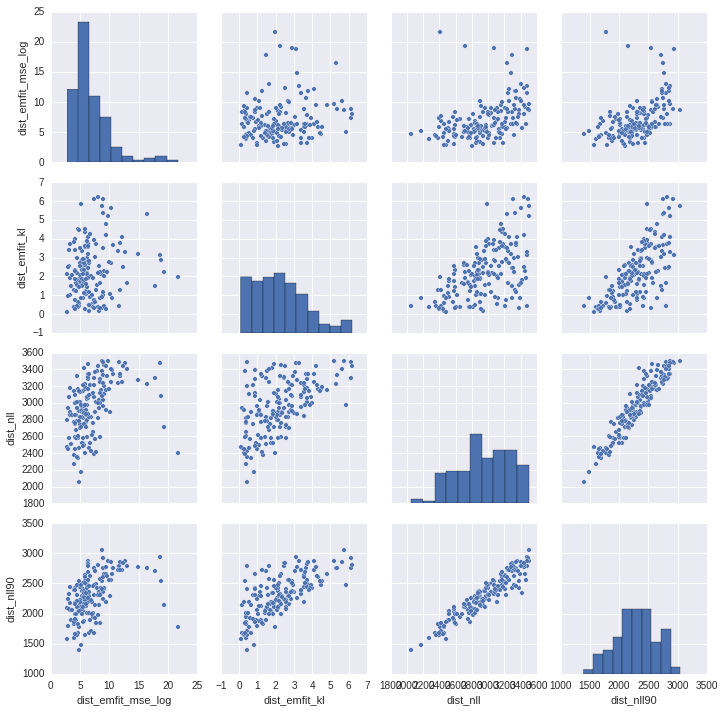

In [40]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             x_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

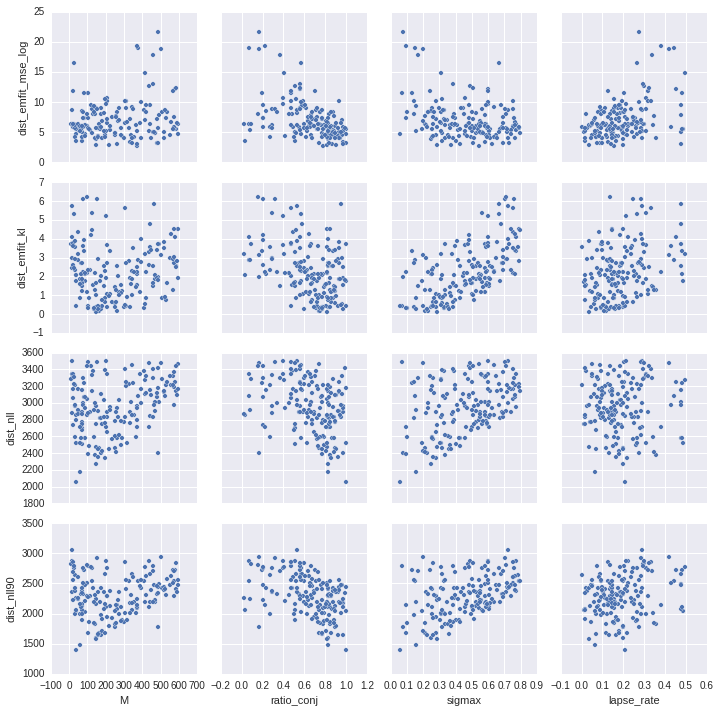

In [41]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

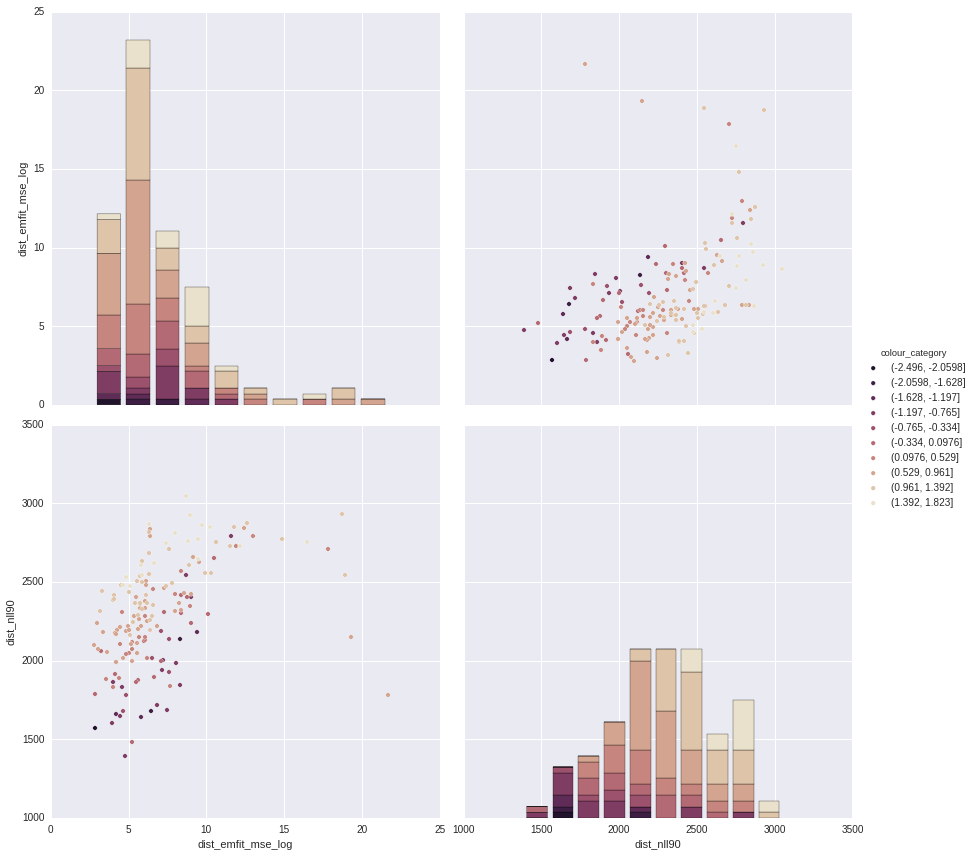

In [42]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_emfit_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_nll90'],
             size = 6
            )

## Plotly Scatter3d

In [43]:
result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title=df_best_fits.columns.values[0],
        ),
        yaxis=YAxis(
            title=df_best_fits.columns.values[1],
        ),
        zaxis=ZAxis(
            title=df_best_fits.columns.values[2],
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [44]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
metric_color_default = 'dist_nll90'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s index' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s index' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

In [45]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Look at best parameters


In [46]:
max_best_params = 10

print_str_best_params_df(df_best_fits, 'dist_emfit_mse', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_emfit_kl', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll90', max_best_params)

Best for dist_emfit_mse
[129] M 371.0000 ratio_conj 0.7790 sigmax 0.5405 lapse_rate 0.1555 >> 16.136057
[228] M 149.0000 ratio_conj 0.8121 sigmax 0.2842 lapse_rate 0.0377 >> 16.829641
[373] M 216.0000 ratio_conj 0.9074 sigmax 0.3717 lapse_rate 0.1965 >> 17.330077
[386] M 373.0000 ratio_conj 0.9678 sigmax 0.6216 lapse_rate 0.1431 >> 19.874044
[281] M 259.0000 ratio_conj 0.8687 sigmax 0.4243 lapse_rate 0.4740 >> 20.639878
[309] M 478.0000 ratio_conj 0.8368 sigmax 0.6911 lapse_rate 0.0758 >> 23.443110
[244] M 346.0000 ratio_conj 0.7399 sigmax 0.5070 lapse_rate 0.0859 >> 25.664212
[325] M 484.0000 ratio_conj 1.0000 sigmax 0.7248 lapse_rate 0.0955 >> 26.929540
[ 34] M 334.0000 ratio_conj 0.9701 sigmax 0.5831 lapse_rate 0.1283 >> 28.189256
[227] M 70.0000 ratio_conj 0.5143 sigmax 0.4007 lapse_rate 0.1640 >> 33.558917

Best for dist_emfit_kl
[228] M 149.0000 ratio_conj 0.8121 sigmax 0.2842 lapse_rate 0.0377 >> 0.082805
[ 20] M 163.0000 ratio_conj 0.7423 sigmax 0.2120 lapse_rate 0.1185 >> 0.13

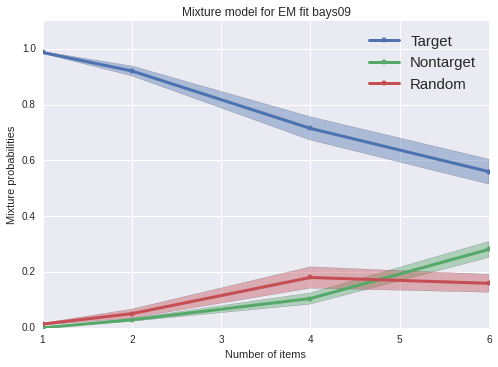

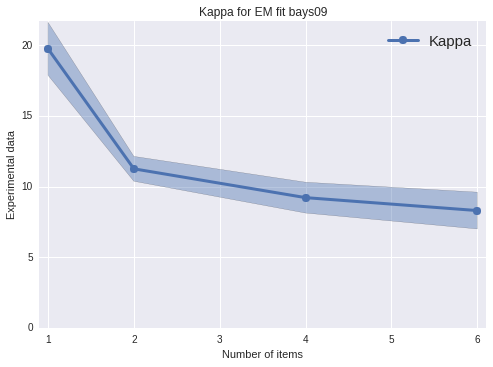

In [47]:
# Ground truth
plots_experimental_data.plots_bays2009(data_groundtruth)

# Plot best
def plot_modelfits(T_space, curr_result_emfits_t, labelplot='', dataio=None):
    curr_result_avg = np.mean(curr_result_emfits_t, axis=-1)
    curr_result_std = np.std(curr_result_emfits_t, axis=-1)
    
    f, ax = plt.subplots()    
    ax = plots_experimental_data.plot_kappa_mean_error(T_space, curr_result_avg[..., 0], curr_result_std[..., 0], title=labelplot, ax=ax, label='Kappa', xlabel='Number of items')

    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_kappa_{label}_{unique_id}.pdf' % labelplot)

    f, ax = plt.subplots()
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 1], curr_result_std[..., 1], title=labelplot, label='Target', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 2], curr_result_std[..., 2], title=labelplot, label='Nontarget', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 3], curr_result_std[..., 3], title=labelplot, label='Random', xlabel='Number of items', ax=ax)
    
    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_mixttarget_{label}_{unique_id}.pdf' % labelplot)

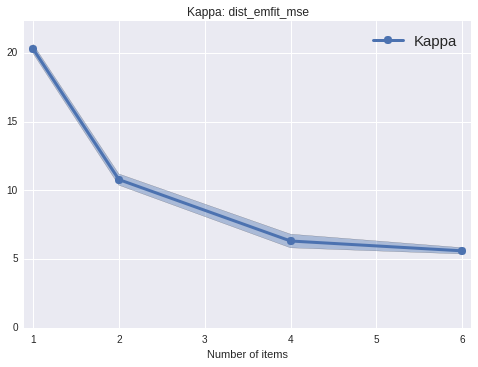

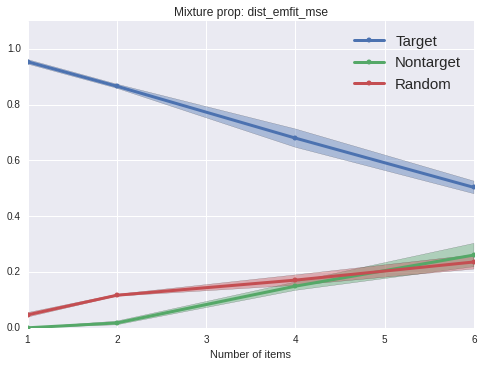

In [48]:
# Best fit for EM MSE
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'])
def plot_model_fit(metric='dist_emfit_mse', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

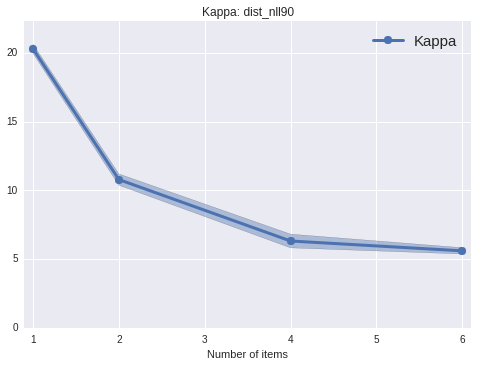

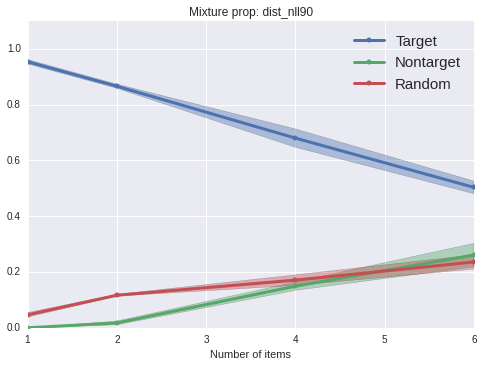

In [49]:
# Best fit for NLL90
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'])
def plot_model_fit(metric='dist_nll90', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

# Observations

I think that the LL requires too high Sigma_output in order to get likely samples.
This corresponds to what I saw before, most points are too unlikely with a very flat sampling posterior, and sigma_output alleviates that.

It's flagrant with the correlation between sigma_output and emfit_MSE, where having sigma_output too high will destroy the fit of Kappas.

Hence we really need to move to another likelihood function, not with sigma_output, but with a baseline lapse rate. This should provide a small amount of support everywhere, without interacting with kappa at all.
Let's hope that will work.

It's unclear if starting CMA/ES runs will be useful or not.